<a href="https://colab.research.google.com/github/charbells/1864093_ProcesamientoDeDatos/blob/main/1864093_Tarea7Codigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
pip install PyWavelets

In [ ]:
import numpy as np
import librosa
import librosa.display
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from datasets import load_dataset
from imblearn.over_sampling import SMOTE


In [ ]:
# Cargar el dataset
ds = load_dataset("danavery/urbansound8K")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Verificar la estructura de un elemento de muestra
print("Ejemplo de estructura de datos:")
print(ds['train'][0])

Ejemplo de estructura de datos:
{'audio': {'path': '100032-3-0-0.wav', 'array': array([-0.00454712, -0.00483704, -0.00460815, ..., -0.00065613,
       -0.00048828,  0.        ]), 'sampling_rate': 44100}, 'slice_file_name': '100032-3-0-0.wav', 'fsID': 100032, 'start': 0.0, 'end': 0.317551, 'salience': 1, 'fold': 5, 'classID': 3, 'class': 'dog_bark'}


Duración: 0.32 segundos
Frecuencia de muestreo: 44100 Hz
Etiqueta: dog_bark


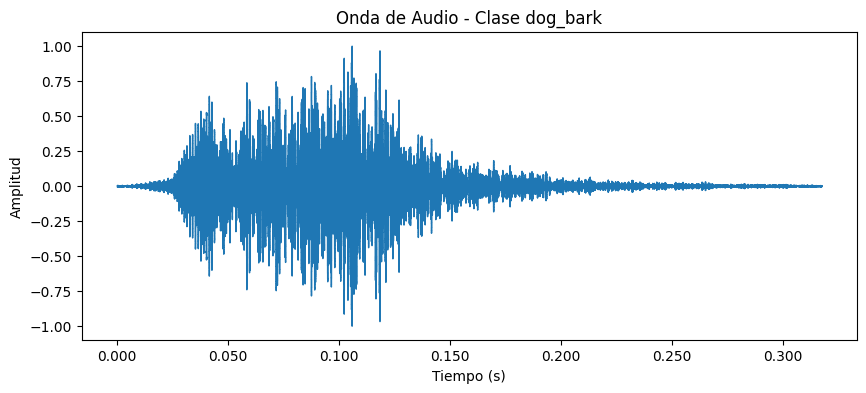

In [ ]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Obtener el primer audio del dataset
audio_data = ds['train'][0]['audio']  # Diccionario con 'array' y 'sampling_rate'
audio = np.array(audio_data['array'])  # Extraer la señal de audio como NumPy array
sr = audio_data['sampling_rate']  # Obtener la frecuencia de muestreo
label = ds['train'][0]['class']  # Obtener la etiqueta de la clase

# Mostrar información
print(f"Duración: {len(audio) / sr:.2f} segundos")
print(f"Frecuencia de muestreo: {sr} Hz")
print(f"Etiqueta: {label}")

# Graficar la forma de onda
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Onda de Audio - Clase {label}")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()

In [ ]:
# 3. Función mejorada de extracción de características
def extract_enhanced_features(audio_dict, target_sr=22050, wavelet='db4', levels=5):
    try:
        audio = audio_dict['array']
        sr = audio_dict['sampling_rate']

        # Resamplear si es necesario para uniformidad
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr

        # Normalización y padding/truncamiento a 4 segundos
        audio = librosa.util.normalize(audio)
        target_length = sr * 4
        if len(audio) > target_length:
            audio = audio[:target_length]
        else:
            audio = np.pad(audio, (0, max(0, target_length - len(audio))), 'constant')

        # Características Wavelet
        coeffs = pywt.wavedec(audio, wavelet, level=levels)
        features = []
        for coeff in coeffs:
            features.extend([np.mean(coeff), np.std(coeff), np.median(coeff),
                           np.min(coeff), np.max(coeff), np.percentile(coeff, 25),
                           np.percentile(coeff, 75)])

        # Características MFCC (13 coeficientes + delta)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        delta_mfccs = librosa.feature.delta(mfccs)
        features.extend(np.mean(mfccs, axis=1))
        features.extend(np.std(mfccs, axis=1))
        features.extend(np.mean(delta_mfccs, axis=1))

        # Características espectrales adicionales
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)

        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff),
            np.mean(zero_crossing_rate), np.std(zero_crossing_rate)
        ])

        return np.array(features)
    except Exception as e:
        print(f"Error procesando audio: {str(e)}")
        return None

In [ ]:
# 4. Extracción de características para todas las muestras
print("\nExtrayendo características...")
X = []
y = []

for sample in ds['train']:
    features = extract_enhanced_features(sample['audio'])
    if features is not None:
        X.append(features)
        y.append(sample['class'])

X = np.array(X)
y = np.array(y)


Extrayendo características...


In [ ]:
# 5. Preprocesamiento y balanceo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalización de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceo con SMOTE (solo en datos de entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
# 6. Arquitectura del modelo mejorada
def build_advanced_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((input_shape[0], 1)),

        layers.Conv1D(128, 5, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Conv1D(256, 5, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.4),

        layers.Conv1D(512, 3, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model


In [ ]:
# 7. Entrenamiento con callbacks
input_shape = (X_train_res.shape[1],)
model = build_advanced_model(input_shape, len(le.classes_))

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train_res, y_train_res,
    epochs=30,
    batch_size=64,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1)

# 8. Evaluación del modelo
model = tf.keras.models.load_model('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nExactitud en prueba: {test_acc:.4f}")

# Reporte de clasificación detallado
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.1909 - loss: 3.3707

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.1913 - loss: 3.3687 - val_accuracy: 0.0275 - val_loss: 3.4819 - learning_rate: 1.0000e-04
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.3280 - loss: 2.8416 - val_accuracy: 0.0208 - val_loss: 4.1279 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.4040 - loss: 2.5652 - val_accuracy: 0.0267 - val_loss: 3.7868 - learning_rate: 1.0000e-04
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4245 - loss: 2.4971

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.4246 - loss: 2.4967 - val_accuracy: 0.1533 - val_loss: 3.1483 - learning_rate: 1.0000e-04
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4696 - loss: 2.3666

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.4696 - loss: 2.3666 - val_accuracy: 0.4325 - val_loss: 2.4775 - learning_rate: 1.0000e-04
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4860 - loss: 2.3038

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.4861 - loss: 2.3036 - val_accuracy: 0.6158 - val_loss: 2.1481 - learning_rate: 1.0000e-04
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5059 - loss: 2.2390

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.5058 - loss: 2.2391 - val_accuracy: 0.6433 - val_loss: 1.9695 - learning_rate: 1.0000e-04
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5243 - loss: 2.2068

107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.5244 - loss: 2.2067 - val_accuracy: 0.6808 - val_loss: 1.9024 - learning_rate: 1.0000e-04
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5331 - loss: 2.1480

107/107 ━━━━━━━━━━━━━━━━━━━━ 49s 302ms/step - accuracy: 0.5331 - loss: 2.1480 - val_accuracy: 0.6817 - val_loss: 1.7848 - learning_rate: 1.0000e-04
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5601 - loss: 2.0791

107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 250ms/step - accuracy: 0.5600 - loss: 2.0792 - val_accuracy: 0.7150 - val_loss: 1.7636 - learning_rate: 1.0000e-04
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5616 - loss: 2.0623

107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 278ms/step - accuracy: 0.5616 - loss: 2.0622 - val_accuracy: 0.7375 - val_loss: 1.6860 - learning_rate: 1.0000e-04
Epoch 12/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5751 - loss: 2.0100

107/107 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.5751 - loss: 2.0102 - val_accuracy: 0.7200 - val_loss: 1.6618 - learning_rate: 1.0000e-04
Epoch 13/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5794 - loss: 2.0085

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.5794 - loss: 2.0085 - val_accuracy: 0.7417 - val_loss: 1.6150 - learning_rate: 1.0000e-04
Epoch 14/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5907 - loss: 1.9611

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.5907 - loss: 1.9611 - val_accuracy: 0.7308 - val_loss: 1.6082 - learning_rate: 1.0000e-04
Epoch 15/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5965 - loss: 1.9364

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.5965 - loss: 1.9364 - val_accuracy: 0.7475 - val_loss: 1.5562 - learning_rate: 1.0000e-04
Epoch 16/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6189 - loss: 1.9047

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.6188 - loss: 1.9047 - val_accuracy: 0.7800 - val_loss: 1.5205 - learning_rate: 1.0000e-04
Epoch 17/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6266 - loss: 1.8795

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.6266 - loss: 1.8794 - val_accuracy: 0.7683 - val_loss: 1.4661 - learning_rate: 1.0000e-04
Epoch 18/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6262 - loss: 1.8685

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.6262 - loss: 1.8683 - val_accuracy: 0.7842 - val_loss: 1.4364 - learning_rate: 1.0000e-04
Epoch 19/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - accuracy: 0.6315 - loss: 1.8514 - val_accuracy: 0.7808 - val_loss: 1.4579 - learning_rate: 1.0000e-04
Epoch 20/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6423 - loss: 1.8106

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.6423 - loss: 1.8105 - val_accuracy: 0.7875 - val_loss: 1.4201 - learning_rate: 1.0000e-04
Epoch 21/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6520 - loss: 1.7697

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.6520 - loss: 1.7697 - val_accuracy: 0.7950 - val_loss: 1.4031 - learning_rate: 1.0000e-04
Epoch 22/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6621 - loss: 1.7472

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.6622 - loss: 1.7471 - val_accuracy: 0.8025 - val_loss: 1.3643 - learning_rate: 1.0000e-04
Epoch 23/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6614 - loss: 1.7299

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.6614 - loss: 1.7300 - val_accuracy: 0.8258 - val_loss: 1.3143 - learning_rate: 1.0000e-04
Epoch 24/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6782 - loss: 1.7077

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - accuracy: 0.6782 - loss: 1.7078 - val_accuracy: 0.8242 - val_loss: 1.3121 - learning_rate: 1.0000e-04
Epoch 25/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.6793 - loss: 1.6786 - val_accuracy: 0.8192 - val_loss: 1.3211 - learning_rate: 1.0000e-04
Epoch 26/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6762 - loss: 1.6592

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.6762 - loss: 1.6593 - val_accuracy: 0.8308 - val_loss: 1.2848 - learning_rate: 1.0000e-04
Epoch 27/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6934 - loss: 1.6434

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.6934 - loss: 1.6434 - val_accuracy: 0.8283 - val_loss: 1.2530 - learning_rate: 1.0000e-04
Epoch 28/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6916 - loss: 1.6328

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.6916 - loss: 1.6327 - val_accuracy: 0.8533 - val_loss: 1.2081 - learning_rate: 1.0000e-04
Epoch 29/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7004 - loss: 1.6048

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.7005 - loss: 1.6047 - val_accuracy: 0.8600 - val_loss: 1.1975 - learning_rate: 1.0000e-04
Epoch 30/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.7079 - loss: 1.5753 - val_accuracy: 0.8542 - val_loss: 1.2003 - learning_rate: 1.0000e-04
Epoch 31/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6955 - loss: 1.5903

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.6956 - loss: 1.5901 - val_accuracy: 0.8742 - val_loss: 1.1526 - learning_rate: 1.0000e-04
Epoch 32/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7123 - loss: 1.5565

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - accuracy: 0.7123 - loss: 1.5564 - val_accuracy: 0.8792 - val_loss: 1.1338 - learning_rate: 1.0000e-04
Epoch 33/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7259 - loss: 1.5323

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.7258 - loss: 1.5324 - val_accuracy: 0.8775 - val_loss: 1.1017 - learning_rate: 1.0000e-04
Epoch 34/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.7301 - loss: 1.5095 - val_accuracy: 0.8733 - val_loss: 1.1065 - learning_rate: 1.0000e-04
Epoch 35/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7241 - loss: 1.5060

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - accuracy: 0.7241 - loss: 1.5060 - val_accuracy: 0.8808 - val_loss: 1.0712 - learning_rate: 1.0000e-04
Epoch 36/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.7349 - loss: 1.4852 - val_accuracy: 0.8800 - val_loss: 1.0773 - learning_rate: 1.0000e-04
Epoch 37/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7386 - loss: 1.4498

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.7386 - loss: 1.4499 - val_accuracy: 0.8775 - val_loss: 1.0556 - learning_rate: 1.0000e-04
Epoch 38/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7341 - loss: 1.4629

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.7342 - loss: 1.4628 - val_accuracy: 0.9000 - val_loss: 1.0026 - learning_rate: 1.0000e-04
Epoch 39/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7528 - loss: 1.4245

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7527 - loss: 1.4245 - val_accuracy: 0.9017 - val_loss: 0.9957 - learning_rate: 1.0000e-04
Epoch 40/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7424 - loss: 1.4329

107/107 ━━━━━━━━━━━━━━━━━━━━ 47s 289ms/step - accuracy: 0.7424 - loss: 1.4328 - val_accuracy: 0.9017 - val_loss: 0.9864 - learning_rate: 1.0000e-04
Epoch 41/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 34s 226ms/step - accuracy: 0.7625 - loss: 1.3782 - val_accuracy: 0.8942 - val_loss: 0.9980 - learning_rate: 1.0000e-04
Epoch 42/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7546 - loss: 1.3986

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.7546 - loss: 1.3984 - val_accuracy: 0.9092 - val_loss: 0.9632 - learning_rate: 1.0000e-04
Epoch 43/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.7674 - loss: 1.3542 - val_accuracy: 0.8917 - val_loss: 0.9954 - learning_rate: 1.0000e-04
Epoch 44/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.7530 - loss: 1.3748 - val_accuracy: 0.8983 - val_loss: 0.9702 - learning_rate: 1.0000e-04
Epoch 45/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7648 - loss: 1.3327

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.7648 - loss: 1.3327 - val_accuracy: 0.9083 - val_loss: 0.9312 - learning_rate: 1.0000e-04
Epoch 46/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.7807 - loss: 1.2931 - val_accuracy: 0.9042 - val_loss: 0.9415 - learning_rate: 1.0000e-04
Epoch 47/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7847 - loss: 1.2777

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.7846 - loss: 1.2779 - val_accuracy: 0.9108 - val_loss: 0.9242 - learning_rate: 1.0000e-04
Epoch 48/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7795 - loss: 1.2843

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.7795 - loss: 1.2843 - val_accuracy: 0.9142 - val_loss: 0.8990 - learning_rate: 1.0000e-04
Epoch 49/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7739 - loss: 1.2819

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.7739 - loss: 1.2818 - val_accuracy: 0.9150 - val_loss: 0.8949 - learning_rate: 1.0000e-04
Epoch 50/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7832 - loss: 1.2777

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.7832 - loss: 1.2776 - val_accuracy: 0.9142 - val_loss: 0.8907 - learning_rate: 1.0000e-04
Epoch 51/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7831 - loss: 1.2674

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - accuracy: 0.7831 - loss: 1.2673 - val_accuracy: 0.9183 - val_loss: 0.8665 - learning_rate: 1.0000e-04
Epoch 52/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - accuracy: 0.8023 - loss: 1.2150 - val_accuracy: 0.9117 - val_loss: 0.8850 - learning_rate: 1.0000e-04
Epoch 53/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.7884 - loss: 1.2473 - val_accuracy: 0.9142 - val_loss: 0.8777 - learning_rate: 1.0000e-04
Epoch 54/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8004 - loss: 1.1928

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.8004 - loss: 1.1928 - val_accuracy: 0.9192 - val_loss: 0.8539 - learning_rate: 1.0000e-04
Epoch 55/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7945 - loss: 1.1945

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.7945 - loss: 1.1945 - val_accuracy: 0.9258 - val_loss: 0.8329 - learning_rate: 1.0000e-04
Epoch 56/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.8086 - loss: 1.1834 - val_accuracy: 0.9283 - val_loss: 0.8332 - learning_rate: 1.0000e-04
Epoch 57/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8023 - loss: 1.1675

107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.8024 - loss: 1.1675 - val_accuracy: 0.9250 - val_loss: 0.8223 - learning_rate: 1.0000e-04
Epoch 58/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8232 - loss: 1.1288

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.8231 - loss: 1.1289 - val_accuracy: 0.9258 - val_loss: 0.8103 - learning_rate: 1.0000e-04
Epoch 59/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8102 - loss: 1.1588

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8102 - loss: 1.1586 - val_accuracy: 0.9308 - val_loss: 0.8008 - learning_rate: 1.0000e-04
Epoch 60/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8152 - loss: 1.1230

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.8152 - loss: 1.1231 - val_accuracy: 0.9375 - val_loss: 0.7884 - learning_rate: 1.0000e-04
Epoch 61/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8110 - loss: 1.1263 - val_accuracy: 0.9350 - val_loss: 0.7905 - learning_rate: 1.0000e-04
Epoch 62/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8190 - loss: 1.1079

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8190 - loss: 1.1079 - val_accuracy: 0.9433 - val_loss: 0.7637 - learning_rate: 1.0000e-04
Epoch 63/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - accuracy: 0.8331 - loss: 1.0778 - val_accuracy: 0.9358 - val_loss: 0.7789 - learning_rate: 1.0000e-04
Epoch 64/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8283 - loss: 1.0755

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.8283 - loss: 1.0756 - val_accuracy: 0.9467 - val_loss: 0.7575 - learning_rate: 1.0000e-04
Epoch 65/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8311 - loss: 1.0740

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.8311 - loss: 1.0739 - val_accuracy: 0.9433 - val_loss: 0.7466 - learning_rate: 1.0000e-04
Epoch 66/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8321 - loss: 1.0523

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.8321 - loss: 1.0524 - val_accuracy: 0.9458 - val_loss: 0.7387 - learning_rate: 1.0000e-04
Epoch 67/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8381 - loss: 1.0446

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 239ms/step - accuracy: 0.8381 - loss: 1.0445 - val_accuracy: 0.9508 - val_loss: 0.7278 - learning_rate: 1.0000e-04
Epoch 68/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8217 - loss: 1.0607

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.8217 - loss: 1.0605 - val_accuracy: 0.9458 - val_loss: 0.7269 - learning_rate: 1.0000e-04
Epoch 69/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8444 - loss: 0.9988

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.8444 - loss: 0.9990 - val_accuracy: 0.9542 - val_loss: 0.7195 - learning_rate: 1.0000e-04
Epoch 70/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8418 - loss: 1.0068

107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.8418 - loss: 1.0068 - val_accuracy: 0.9558 - val_loss: 0.7042 - learning_rate: 1.0000e-04
Epoch 71/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.8430 - loss: 1.0035 - val_accuracy: 0.9542 - val_loss: 0.7104 - learning_rate: 1.0000e-04
Epoch 72/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8530 - loss: 0.9902 - val_accuracy: 0.9475 - val_loss: 0.7073 - learning_rate: 1.0000e-04
Epoch 73/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8540 - loss: 0.9699

107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 267ms/step - accuracy: 0.8540 - loss: 0.9700 - val_accuracy: 0.9533 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 74/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8546 - loss: 0.9702

107/107 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8546 - loss: 0.9702 - val_accuracy: 0.9517 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 75/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8530 - loss: 0.9585

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.8530 - loss: 0.9586 - val_accuracy: 0.9492 - val_loss: 0.6793 - learning_rate: 1.0000e-04
Epoch 76/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8586 - loss: 0.9491

107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.8586 - loss: 0.9491 - val_accuracy: 0.9567 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 77/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8578 - loss: 0.9461 - val_accuracy: 0.9525 - val_loss: 0.6729 - learning_rate: 1.0000e-04
Epoch 78/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8632 - loss: 0.9384

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8632 - loss: 0.9385 - val_accuracy: 0.9617 - val_loss: 0.6499 - learning_rate: 1.0000e-04
Epoch 79/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - accuracy: 0.8554 - loss: 0.9345 - val_accuracy: 0.9558 - val_loss: 0.6520 - learning_rate: 1.0000e-04
Epoch 80/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8592 - loss: 0.9226

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.8592 - loss: 0.9226 - val_accuracy: 0.9608 - val_loss: 0.6426 - learning_rate: 1.0000e-04
Epoch 81/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8637 - loss: 0.9074

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8636 - loss: 0.9075 - val_accuracy: 0.9592 - val_loss: 0.6379 - learning_rate: 1.0000e-04
Epoch 82/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8689 - loss: 0.8987

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.8689 - loss: 0.8988 - val_accuracy: 0.9633 - val_loss: 0.6346 - learning_rate: 1.0000e-04
Epoch 83/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8677 - loss: 0.8967

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.8677 - loss: 0.8966 - val_accuracy: 0.9642 - val_loss: 0.6280 - learning_rate: 1.0000e-04
Epoch 84/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8650 - loss: 0.8975

107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.8650 - loss: 0.8973 - val_accuracy: 0.9658 - val_loss: 0.6182 - learning_rate: 1.0000e-04
Epoch 85/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8719 - loss: 0.8819

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.8719 - loss: 0.8819 - val_accuracy: 0.9658 - val_loss: 0.6112 - learning_rate: 1.0000e-04
Epoch 86/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8724 - loss: 0.8690

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.8724 - loss: 0.8690 - val_accuracy: 0.9658 - val_loss: 0.6057 - learning_rate: 1.0000e-04
Epoch 87/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.8798 - loss: 0.8552 - val_accuracy: 0.9667 - val_loss: 0.6077 - learning_rate: 1.0000e-04
Epoch 88/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8722 - loss: 0.8492

107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.8722 - loss: 0.8492 - val_accuracy: 0.9667 - val_loss: 0.6005 - learning_rate: 1.0000e-04
Epoch 89/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.8783 - loss: 0.8393 - val_accuracy: 0.9642 - val_loss: 0.6049 - learning_rate: 1.0000e-04
Epoch 90/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8727 - loss: 0.8379

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.8728 - loss: 0.8379 - val_accuracy: 0.9650 - val_loss: 0.5984 - learning_rate: 1.0000e-04
Epoch 91/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8830 - loss: 0.8189

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.8831 - loss: 0.8189 - val_accuracy: 0.9708 - val_loss: 0.5836 - learning_rate: 1.0000e-04
Epoch 92/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8843 - loss: 0.8212

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.8843 - loss: 0.8212 - val_accuracy: 0.9658 - val_loss: 0.5801 - learning_rate: 1.0000e-04
Epoch 93/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8919 - loss: 0.8008

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.8919 - loss: 0.8009 - val_accuracy: 0.9692 - val_loss: 0.5789 - learning_rate: 1.0000e-04
Epoch 94/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8872 - loss: 0.8054

107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.8872 - loss: 0.8054 - val_accuracy: 0.9667 - val_loss: 0.5782 - learning_rate: 1.0000e-04
Epoch 95/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8893 - loss: 0.8019

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.8894 - loss: 0.8018 - val_accuracy: 0.9683 - val_loss: 0.5721 - learning_rate: 1.0000e-04
Epoch 96/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.8915 - loss: 0.7970 - val_accuracy: 0.9667 - val_loss: 0.5757 - learning_rate: 1.0000e-04
Epoch 97/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9010 - loss: 0.7664

107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.9010 - loss: 0.7664 - val_accuracy: 0.9667 - val_loss: 0.5684 - learning_rate: 1.0000e-04
Epoch 98/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9004 - loss: 0.7602

107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.9003 - loss: 0.7603 - val_accuracy: 0.9692 - val_loss: 0.5583 - learning_rate: 1.0000e-04
Epoch 99/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 233ms/step - accuracy: 0.8956 - loss: 0.7598 - val_accuracy: 0.9692 - val_loss: 0.5633 - learning_rate: 1.0000e-04
Epoch 100/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.8954 - loss: 0.7529 - val_accuracy: 0.9692 - val_loss: 0.5594 - learning_rate: 1.0000e-04


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8626 - loss: 0.9594

Exactitud en prueba: 0.8729
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

 air_conditioner       0.91      0.91      0.91       200
        car_horn       0.81      0.85      0.83        86
children_playing       0.85      0.78      0.81       200
        dog_bark       0.94      0.83      0.88       200
        drilling       0.90      0.86      0.88       200
   engine_idling       0.93      0.91      0.92       200
        gun_shot       0.86      0.97      0.91        75
      jackhammer       0.84      0.90      0.87       200
           siren       0.91      0.92      0.92       186
    street_music       0.77      0.84      0.80       200

        accuracy                           0.87      1747
       macro avg       0.87      0.88      0.87      1747
    weighted avg       0.88      0.87      0.87      1747



In [ ]:
# 8. Evaluación del modelo
model = tf.keras.models.load_model('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nExactitud en prueba: {test_acc:.4f}")

# Reporte de clasificación detallado
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8626 - loss: 0.9594

Exactitud en prueba: 0.8729
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

 air_conditioner       0.91      0.91      0.91       200
        car_horn       0.81      0.85      0.83        86
children_playing       0.85      0.78      0.81       200
        dog_bark       0.94      0.83      0.88       200
        drilling       0.90      0.86      0.88       200
   engine_idling       0.93      0.91      0.92       200
        gun_shot       0.86      0.97      0.91        75
      jackhammer       0.84      0.90      0.87       200
           siren       0.91      0.92      0.92       186
    street_music       0.77      0.84      0.80       200

        accuracy                           0.87      1747
       macro avg       0.87      0.88      0.87      1747
    weighted avg       0.88      0.87      0.87      1747



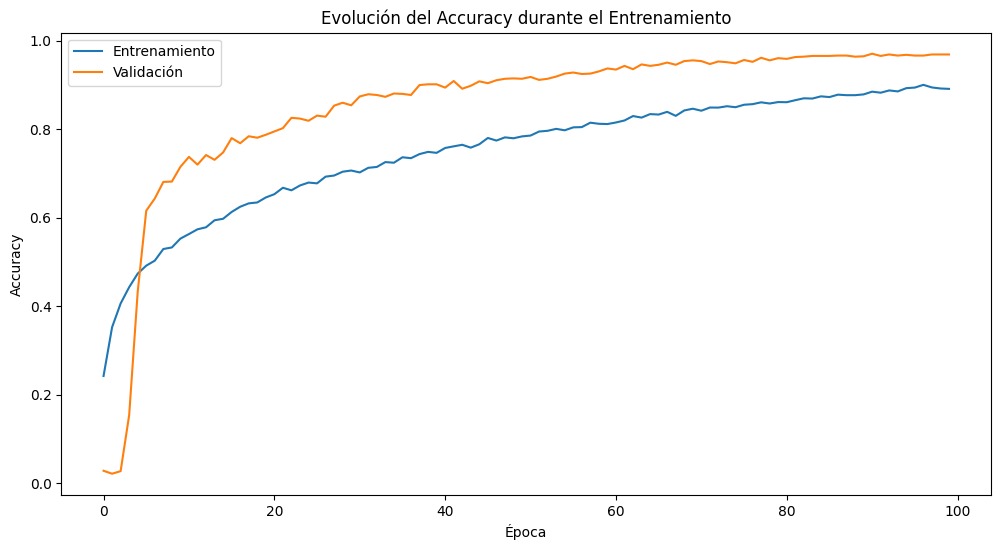

In [ ]:
# 9. Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución del Accuracy durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()